In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

import matplotlib.pyplot as plt

/home/b.y.yang/miniconda3/envs/ese5934/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load trained model

In [3]:
# device = 'cuda:1'
device = "cpu"
conf = brats_autoenc()
print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0



Model params: 122.59 M


# Load images into dataset

In [3]:
# define transforms
bbox_slice_row = slice(22, 216, None)
bbox_slice_col = slice(29, 223, None)
transform_seq = Compose([
    LoadImaged(keys = ["img"]),
    Squeeze2Dd(keys = ["img"]),
    SpatialCropd(keys = ["img"], roi_slices = [bbox_slice_row, bbox_slice_col, slice(None)]),
    ScaleIntensityd(keys = ["img"]),
    Resized(keys = ["img"], spatial_size = (128, 128), size_mode = "all"),  # resize to 1 x 128 x 128
    GrayscaleToRGBd(keys = ["img"]),
    ToTensord(keys = ["img"]),
])

In [5]:
cache_dir = mkdtemp(dir = "/scratch/b.y.yang")
dataset_df = pd.read_csv("/scratch/b.y.yang/ESE5934-project/data/dataset.csv")
test_df = pd.read_csv("/scratch/b.y.yang/ESE5934-project/data/test.csv")
# dataset_df = dataset_df.iloc[:2, :]
all_data = PersistentDataset(
    data = [{"img": nii_path} for nii_path in dataset_df["slice_path"]],
    transform = transform_seq,
    cache_dir = cache_dir
)
test_data = PersistentDataset(
    data = [{"img": nii_path} for nii_path in test_df["slice_path"]],
    transform = transform_seq,
    cache_dir = cache_dir
)

Example slices:
- with tumor: 508, 710
- without tumor: 200, 1493

Test slices:
- 165, 380, 550, 600

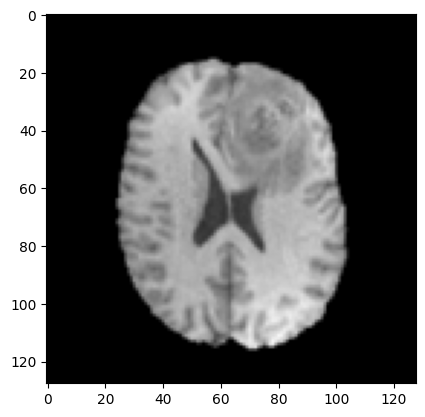

In [20]:
idx = 600
plt.imshow(test_data[idx]["img"].permute([2, 1, 0]))
# plt.imshow(all_data[idx]["img"])

In [ ]:
plt.imshow()

# Get slice

In [8]:
# data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = all_data[1]['img'][None]

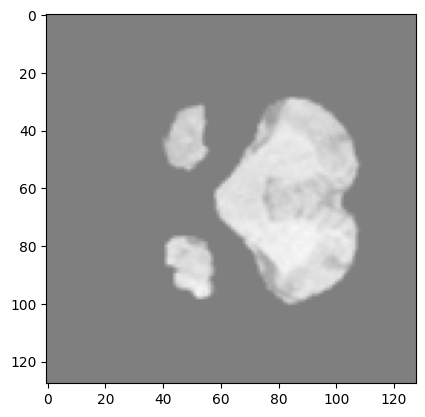

In [11]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

# Encode

In [12]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

/home/b.y.yang/miniconda3/envs/ese5934/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


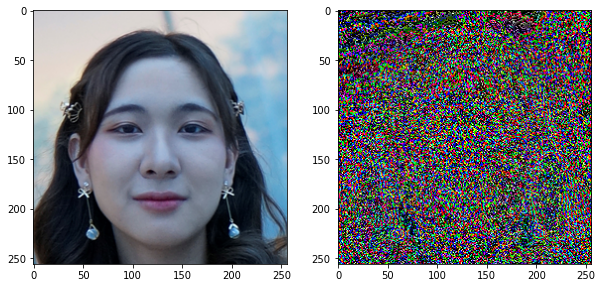

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

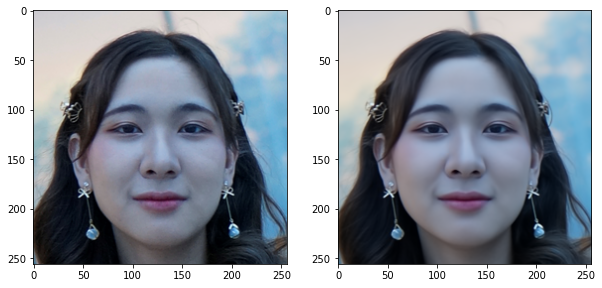

In [ ]:
pred = model.render(xT, cond, T=20)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())